In [ ]:
!nvidia-smi

Tue Dec 14 08:20:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/gnobitab/FuseDream.git
!pip install ftfy regex tqdm numpy scipy h5py lpips==0.1.4
!pip install git+https://github.com/openai/CLIP.git
!pip install gdown
!gdown 'https://drive.google.com/uc?id=17ymX6rhsgHDZw_g5XgAFW4xLSDocARCM'
!gdown 'https://drive.google.com/uc?id=1sOZ9og9kJLsqMNhaDnPJgzVsBZQ1sjZ5'

Cloning into 'FuseDream'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 124 (delta 40), reused 107 (delta 26), pack-reused 0
Receiving objects: 100% (124/124), 8.24 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (40/40), done.
     |████████████████████████████████| 64 kB 1.8 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=f6e9c9563e0fb1982d4ce4569e00d69b3c122f3653d29a933c897259e49ad3f8
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dehy5d7o
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-dehy5d7o
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=31afc886a099d0a8d6b9370d1

In [ ]:
!ls
!cp biggan-256.pth FuseDream/BigGAN_utils/weights/
!cp biggan-512.pth FuseDream/BigGAN_utils/weights/
%cd FuseDream

biggan-256.pth	biggan-512.pth	FuseDream  sample_data
/content/FuseDream


In [2]:
import torch
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torchvision
import BigGAN_utils.utils as utils
import clip
import torch.nn.functional as F
from DiffAugment_pytorch import DiffAugment
import numpy as np
from fusedream_utils import FuseDreamBaseGenerator, get_G, save_image

ModuleNotFoundError: No module named 'BigGAN_utils'

In [1]:
#@title Parameters
SENTENCE = "Temple in the sunrise." #@param {type:"string"}
INIT_ITERS =  1000#@param {type:"number"}
OPT_ITERS = 1000#@param {type:"number"}
NUM_BASIS = 5#@param {type:"number"}
MODEL = "biggan-256" #@param ["biggan-256","biggan-512"]
SEED = 0#@param {type:"number"}

import sys
sys.argv = [''] ### workaround to deal with the argparse in Jupyter

Generating: Temple in the sunrise.
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 1000/1000 [40:26<00:00,  2.43s/it]


AugCLIP score: 0.3598876953125


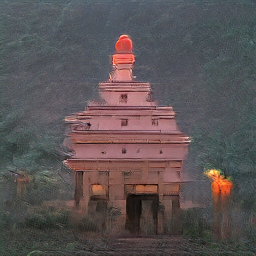

In [ ]:
### Generation: Click the 'run' button and the final generated image will be shown after the end of the algorithm
utils.seed_rng(SEED)

sentence = SENTENCE

print('Generating:', sentence)
if MODEL == "biggan-256":
    G, config = get_G(256)
elif MODEL == "biggan-512":
    G, config = get_G(512)
else:
    raise Exception('Model not supported')
generator = FuseDreamBaseGenerator(G, config, 10)
z_cllt, y_cllt = generator.generate_basis(sentence, init_iters=INIT_ITERS, num_basis=NUM_BASIS)

z_cllt_save = torch.cat(z_cllt).cpu().numpy()
y_cllt_save = torch.cat(y_cllt).cpu().numpy()
img, z, y = generator.optimize_clip_score(z_cllt, y_cllt, sentence, latent_noise=False, augment=True, opt_iters=OPT_ITERS, optimize_y=True)
### Set latent_noise = True yields slightly higher AugCLIP score, but slightly lower image quality. We set it to False for dogs.
score = generator.measureAugCLIP(z, y, sentence, augment=True, num_samples=20)
print('AugCLIP score:', score)
import os
if not os.path.exists('./samples'):
    os.mkdir('./samples')
save_image(img, 'samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score))

from IPython import display
display.display(display.Image('samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score)))